# PROJET IML

In [1]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import sklearn
%matplotlib inline

In [2]:
# import de la donnée
arr_pines = np.load("./data/indianapines.npy")

In [3]:
# import de la vérité terrain
arr_pines_gt = np.load("./data/indianapines_gt.npy")

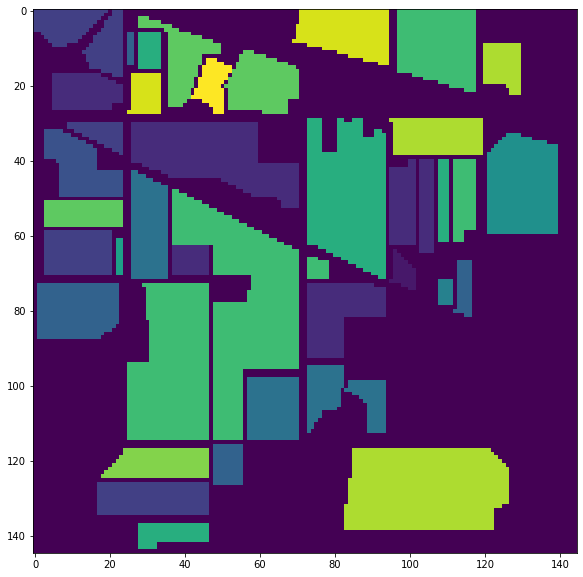

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(arr_pines_gt, cmap="viridis")

In [5]:
labels = ["Unknown", "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", 
          "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean",
          "Wheat", "Woods", "Building-Grass-Tree-Drives", "Stone-Steel-Towers"]
labels

['Unknown',
 'Alfalfa',
 'Corn-notill',
 'Corn-mintill',
 'Corn',
 'Grass-pasture',
 'Grass-trees',
 'Grass-pasture-mowed',
 'Hay-windrowed',
 'Oats',
 'Soybean-notill',
 'Soybean-mintill',
 'Soybean-clean',
 'Wheat',
 'Woods',
 'Building-Grass-Tree-Drives',
 'Stone-Steel-Towers']

(9604, 955)

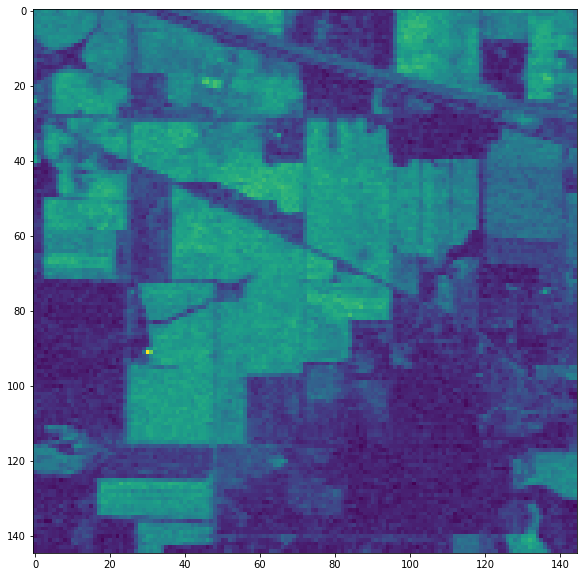

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(arr_pines[:,:,150])
arr_pines.max(), arr_pines.min()

In [7]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [8]:
print("arr_pines has", arr_pines.shape[2], "dim")
arr_pines.min(), arr_pines.max()

arr_pines has 200 dim


(955, 9604)

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.
Wikipedia donne :
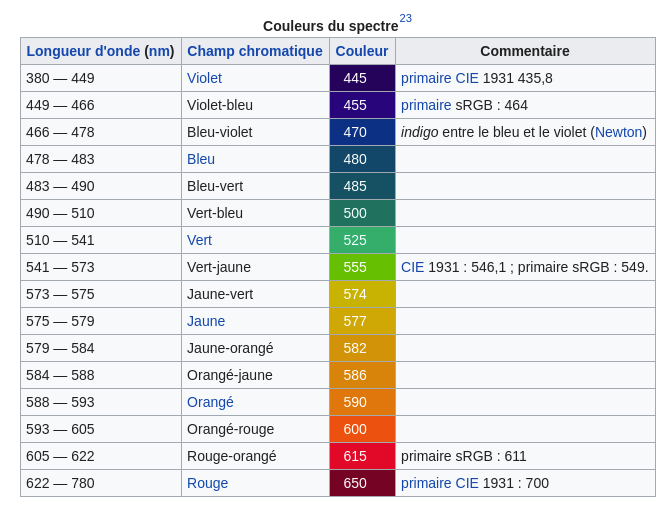

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [9]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)

In [10]:
r = find_index_wavelength(611)
g = find_index_wavelength(549)
b = find_index_wavelength(464)
rgb_pines = arr_pines[:,:,[r, g, b]]

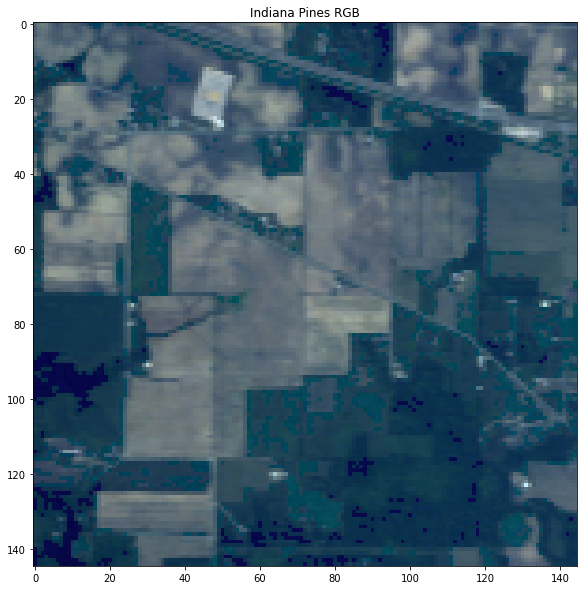

In [11]:
plt.figure(figsize=(10,10))
plt.title("Indiana Pines RGB")
plt.imshow(normalize(rgb_pines))
row,col,dim = arr_pines.shape

## Creation of train, test sets
We will first retrieve all the hyperspectral pixels and sort them according to their given class

In [13]:
from sklearn.model_selection import train_test_split
X = arr_pines.reshape((-1, dim))
y = arr_pines_gt.reshape((-1))
# X = arr_pines.copy()
# y = arr_pines_gt.copy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [15]:
np.round(np.unique(y_train, return_counts=True)[1] / (y_train.shape[0]) * 100)

array([51.,  0.,  7.,  5.,  1.,  3.,  3.,  0.,  2.,  0.,  4., 10.,  3.,
        1.,  6.,  2.,  0.])

In [16]:
np.round(np.unique(y_test, return_counts=True)[1] / (y_test.shape[0]) * 100)

array([51.,  0.,  7.,  4.,  1.,  2.,  4.,  0.,  2.,  0.,  5., 12.,  3.,
        1.,  6.,  2.,  0.])

In [17]:
X_train.shape, y_train.shape

((4205, 200), (4205,))

In [18]:
nb_comp = 10

In [19]:
from sklearn import decomposition
def reduc_dim(X, nb_comp):
    pca = sklearn.decomposition.PCA()
    pca.fit(X)
    return pca.transform(X)[:,:nb_comp], pca

## With `DecisionTreeClassifier`

In [20]:
X_train, pca = reduc_dim(X_train, nb_comp)

In [21]:
X_train.shape

(4205, 10)

In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [24]:
X_test = pca.transform(X_test)[:,:nb_comp]

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      8625
           1       0.50      0.28      0.36        54
           2       0.41      0.43      0.42      1081
           3       0.47      0.37      0.42       819
           4       0.32      0.26      0.29       226
           5       0.52      0.48      0.50       399
           6       0.55      0.54      0.55       599
           7       0.52      0.46      0.49        24
           8       0.79      0.78      0.78       384
           9       0.00      0.00      0.00        22
          10       0.51      0.55      0.53       736
          11       0.58      0.65      0.61      1794
          12       0.32      0.35      0.33       442
          13       0.66      0.76      0.71       143
          14       0.46      0.42      0.44      1087
          15       0.09      0.08      0.08       326
          16       0.58      0.75      0.65        59

    accuracy              

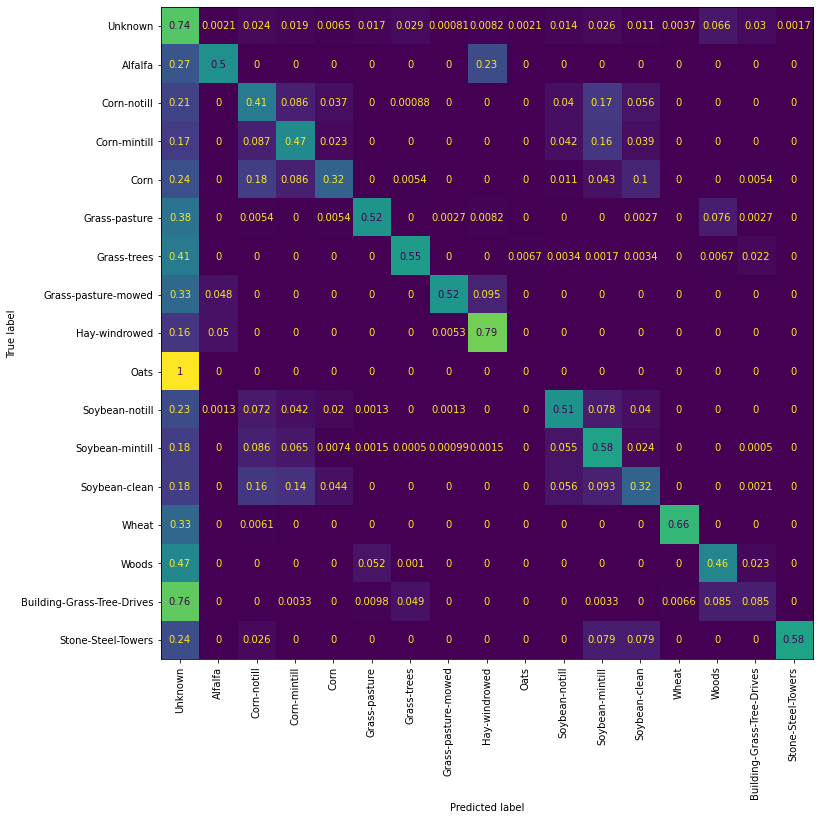

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, display_labels=labels,
                      xticks_rotation="vertical",normalize="true",
                     colorbar=False)
y_predicted = clf.predict(X_test)
# round(len(np.where(y_predicted == y_test)[0]) / len(y_test) * 100, 2)
print(classification_report(y_predicted, y_test))

### Show result

In [26]:
import skimage
from skimage.morphology import opening, closing

In [60]:
def showLabelisedImage(image, /, new_plot=False):
    if new_plot:
        plt.figure()
    plt.imshow(image, cmap="viridis")

def computeResult(image_input, pca, nb_comp):
    image = image_input.copy()
    image_flat = image.reshape((-1, image.shape[2]))
    image_pca = pca.transform(image_flat)[:,:nb_comp]
    y_predicted = clf.predict(image_pca)
    result = y_predicted.reshape(arr_pines.shape[:2])
    return result
    
def sharpenResult(result):
    my_result = result.copy()
    for i in range(1, result.max() + 1):
        classResult = my_result == i
        my_result[classResult] = 0
        
        plt.figure()
        plt.subplots(figsize=(15,15))

        plt.subplot(131)
        showLabelisedImage(classResult)
        
        classResult = skimage.morphology.remove_small_objects(classResult, 12)
        plt.subplot(132)
        showLabelisedImage(classResult)
        
        classResult = skimage.morphology.remove_small_holes(classResult, 8)
        classResult = skimage.morphology.closing(classResult, skimage.morphology.square(5))
        classResult = skimage.morphology.opening(classResult, skimage.morphology.square(3))
        plt.subplot(133)
        showLabelisedImage(classResult)
        
        my_result[classResult] = i
    return my_result

(16820,)


<ipython-input-60-a4602401e5e6>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


(16820,)

<Figure size 432x288 with 0 Axes>

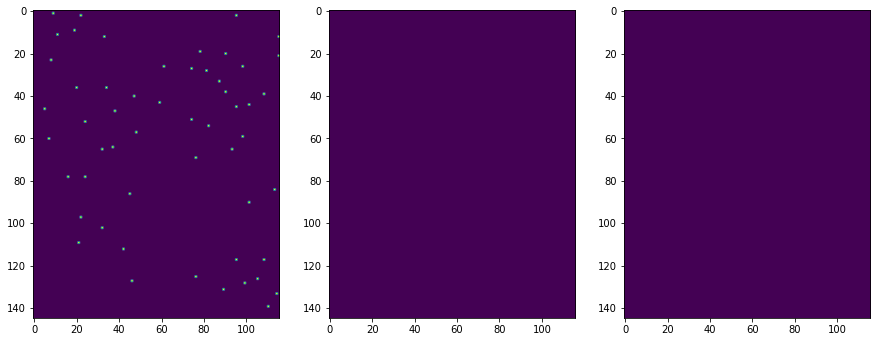

<Figure size 432x288 with 0 Axes>

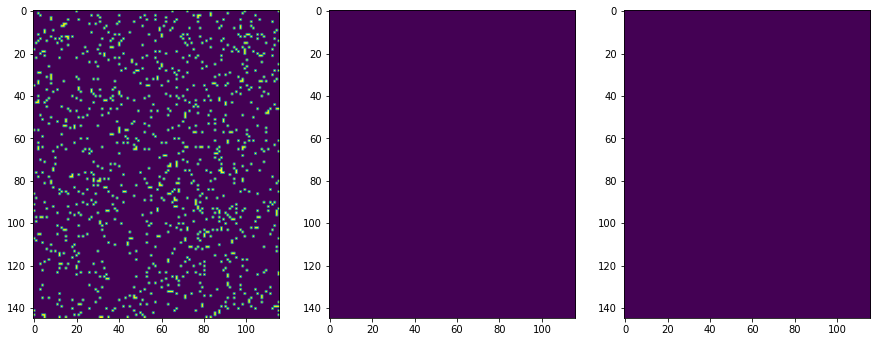

<Figure size 432x288 with 0 Axes>

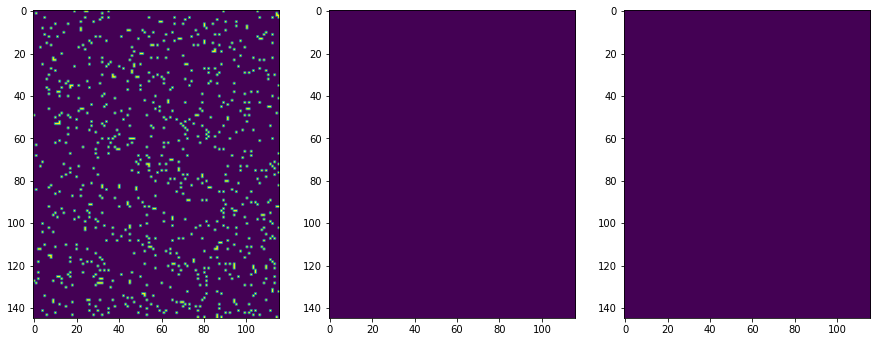

<Figure size 432x288 with 0 Axes>

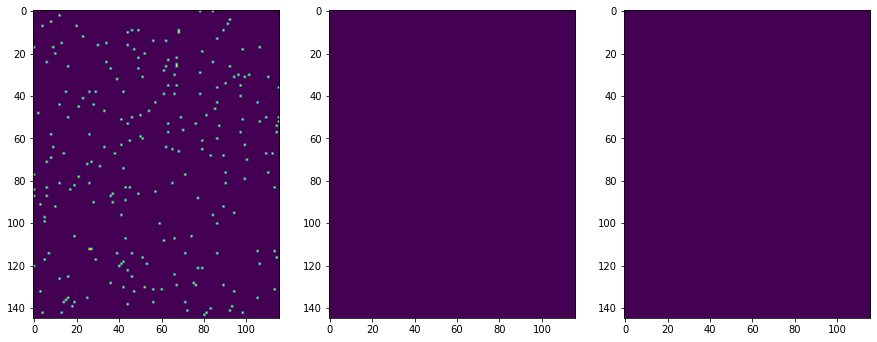

<Figure size 432x288 with 0 Axes>

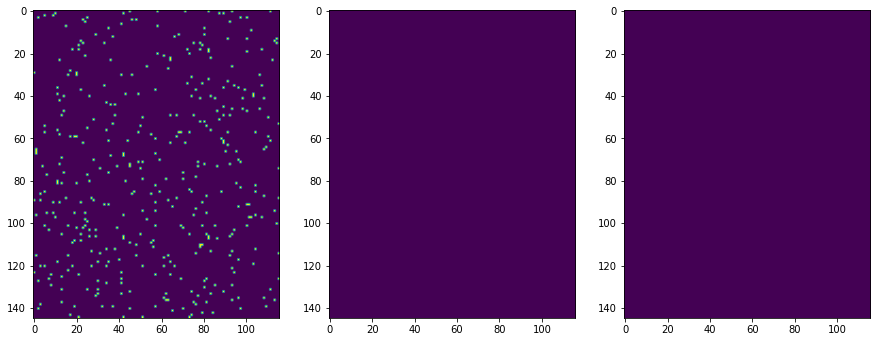

<Figure size 432x288 with 0 Axes>

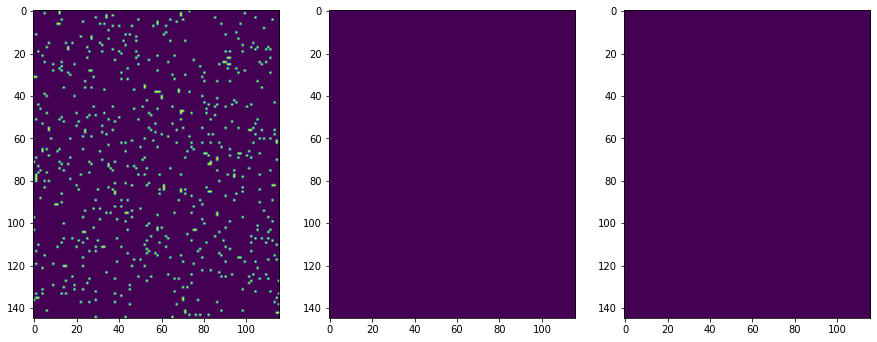

<Figure size 432x288 with 0 Axes>

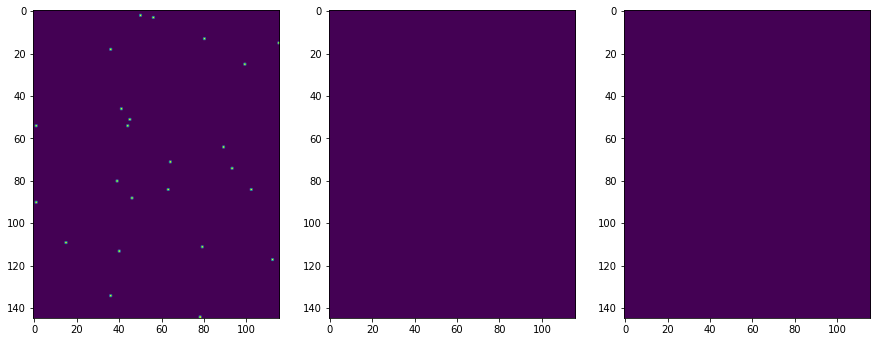

<Figure size 432x288 with 0 Axes>

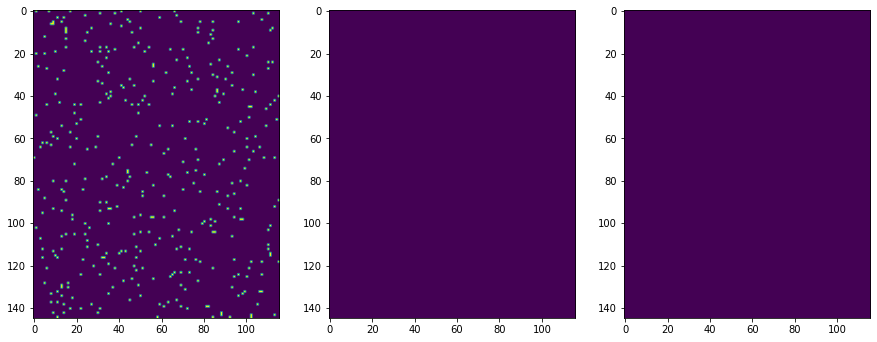

<Figure size 432x288 with 0 Axes>

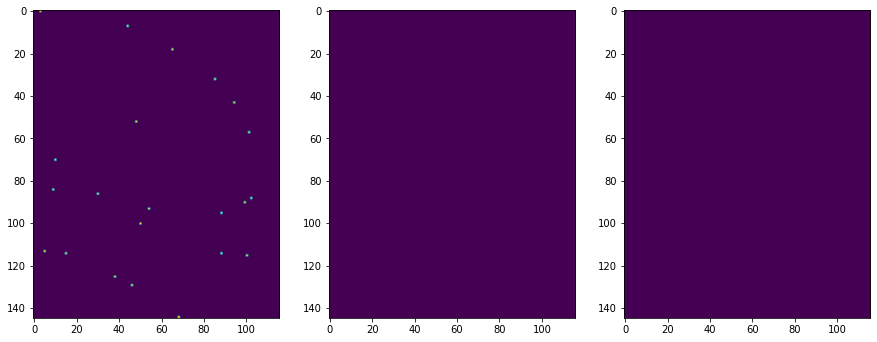

<Figure size 432x288 with 0 Axes>

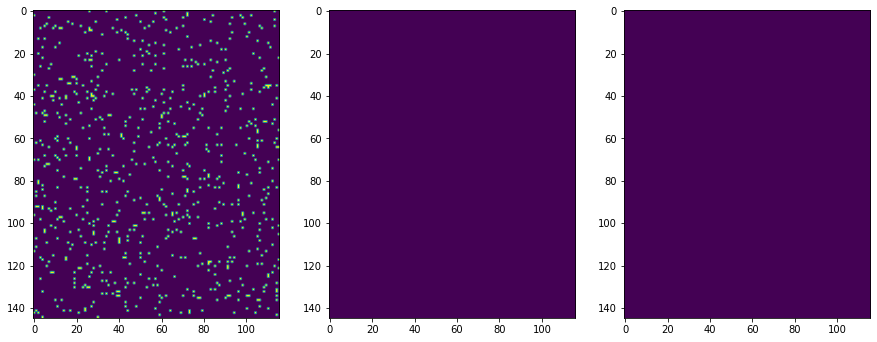

<Figure size 432x288 with 0 Axes>

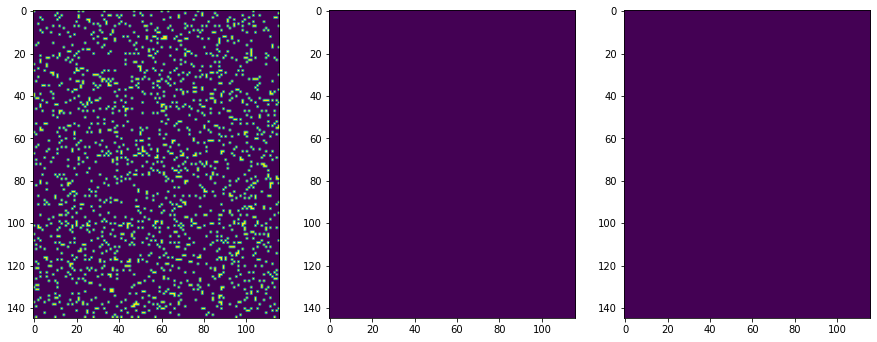

<Figure size 432x288 with 0 Axes>

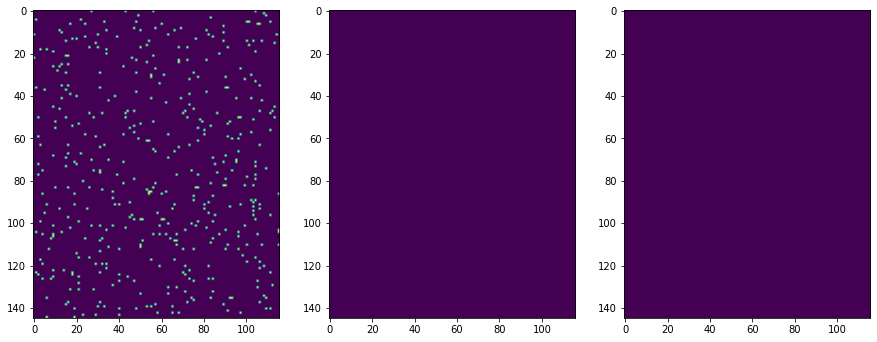

<Figure size 432x288 with 0 Axes>

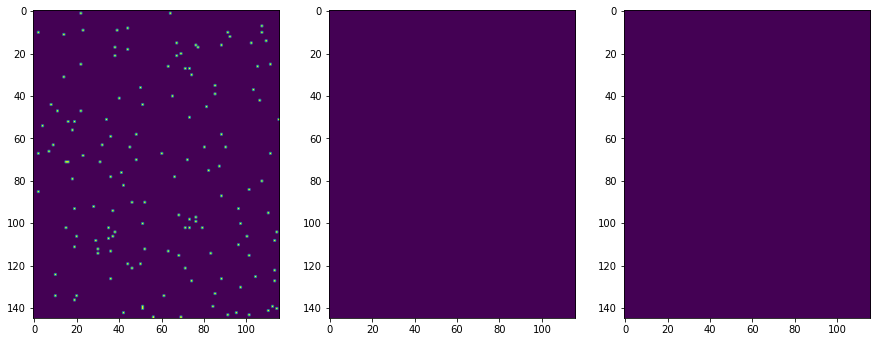

<Figure size 432x288 with 0 Axes>

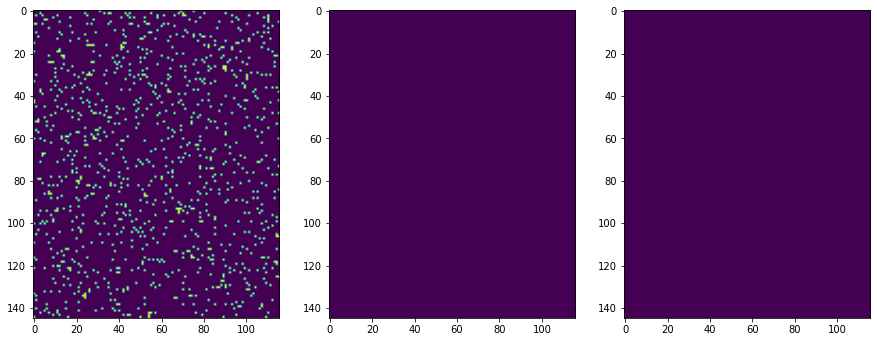

<Figure size 432x288 with 0 Axes>

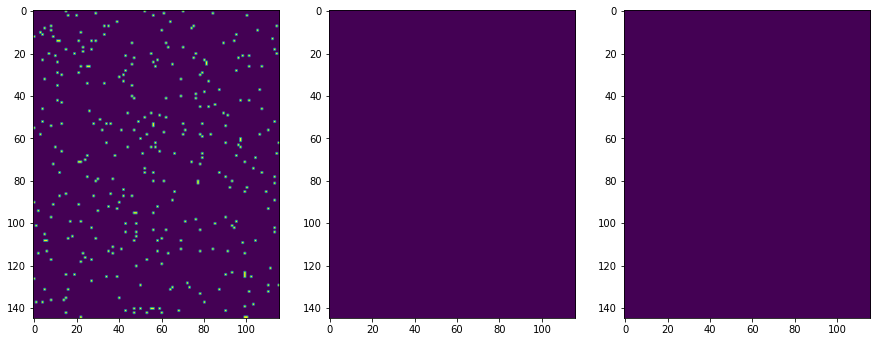

<Figure size 432x288 with 0 Axes>

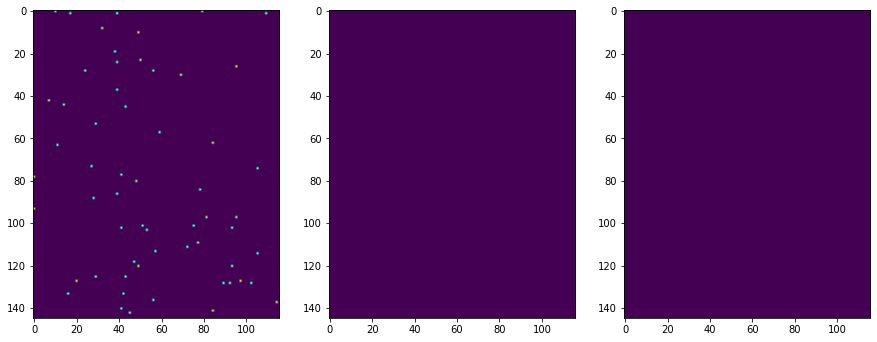

In [61]:
print(y_predicted.shape)
result = computeResult(arr_pines, pca, nb_comp)
sharpen_result = sharpenResult(y_predicted.reshape((145, 116)))
sharpen_result.reshape((-1)).shape
# Plot globally
# plt.subplots(figsize=(15,15))
# plt.subplot(131)
# showLabelisedImage(arr_pines_gt)
# plt.subplot(132)
# showLabelisedImage(result)
# plt.subplot(133)
# showLabelisedImage(sharpen_result)

In [58]:
sharpen_result = sharpen_result.reshape((-1))
sharpen_result.shape

(16820,)

In [59]:
print(classification_report(sharpen_result, y_test))

              precision    recall  f1-score   support

           0       1.00      0.51      0.68     16820
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0

    accuracy              

/home/dominique/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dominique/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dominique/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
tmp_img = sharpen_result.reshape((145, 116))

## Dimension reduction

In [ ]:
arr_pines_flat = arr_pines.reshape((-1, dim))
# X.reshape((row, col, dim)).shape

In [ ]:
Sigma = np.corrcoef(arr_pines_flat,rowvar=False)
plt.figure(figsize=(10,10))
plt.title('Correlation entre les données')
plt.imshow(Sigma)

In [ ]:
import sklearn.decomposition
pca_pines = sklearn.decomposition.PCA()
pca_pines.fit(arr_pines_flat)

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Explained variance per PC')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.subplot(122)
plt.title('Explained variance per PC (in log scale)')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.yscale('log')
plt.show()

In [ ]:
nb_comp = 10

In [ ]:
pines_projected = pca_hsi.transform(arr_pines_flat)
pines_projected_small = pines_projected[:,:nb_comp].reshape((row,col,10))

In [ ]:
plt.figure(figsize=(30,15))
for i in range(nb_comp):
    plt.subplot(2,5,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(pines_projected_small[:,:,i],cmap='gray')
plt.show()

In [ ]:
pines_projected_full = pines_projected.copy()
pines_projected_full[:,10:] = 0
pines_proj_back = pca_pines.inverse_transform(pines_projected_full).reshape((row,col,dim))

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(normalize(rgb_pines))
plt.subplot(122)
plt.imshow(normalize(pines_proj_back[:,:,[r, g, b]]))
plt.show()

In [ ]:
pines_projected_small.shape